# Рекомендательная модель для телеком-компании

В моем распоряжении предобработанный датасес с историческими данными о поведении клиентов. Датасет содержит такие признаки, как: используемый пользователем тариф, ежемесячные расходы разных услуг (минуты разговора, количество сообщенийи интернет-трафика). 

Метрика:  *accuracy*

## Откройте и изучите файл

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats as st
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display_html
from IPython.core.display import display, HTML
# импорт библиотеки pandas
# импорт библиотеки numpy
# импортируем библиотеку matplotlib модуль pyplot
# импорт библиотеки seaborn
# импорт библиотеки scipy
# импорт алгоритма решающего дерева из библиотеки sklearn
# импорт алгоритма случайный лес из библиотеки sklearn
# импорт алгоритма логистическая регрессия из библиотеки sklearn
# импортируем функцию train_test_split из библиотеки sklearn
# импортируем функцию расчёта accuracy из библиотеки sklearn
# импортируем функцию расчёта mean_squared_error из библиотеки sklearn
# включим игнорирование предупреждений
# импорт модуля display_html из библиотеки IPython
# импорт display, HTML из библиотеки IPython


# библиотеки, которых нет на сервере
import sweetviz
import pandas_profiling

C:\Users\play_\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\play_\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

In [4]:
# чтение файла с данными и сохранение в переменной df
# убираем ограничение по выводу столбцов
df = pd.read_csv('users_behavior.csv',sep=',')
pd.set_option('display.max_columns', None)

In [6]:
# получение первых 10 строк таблицы 
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [7]:
# получение общей информации о данных в таблице df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [8]:
# соберем общие статистические данные по df
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [9]:
# выведем пропуски по всем столбцам df
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

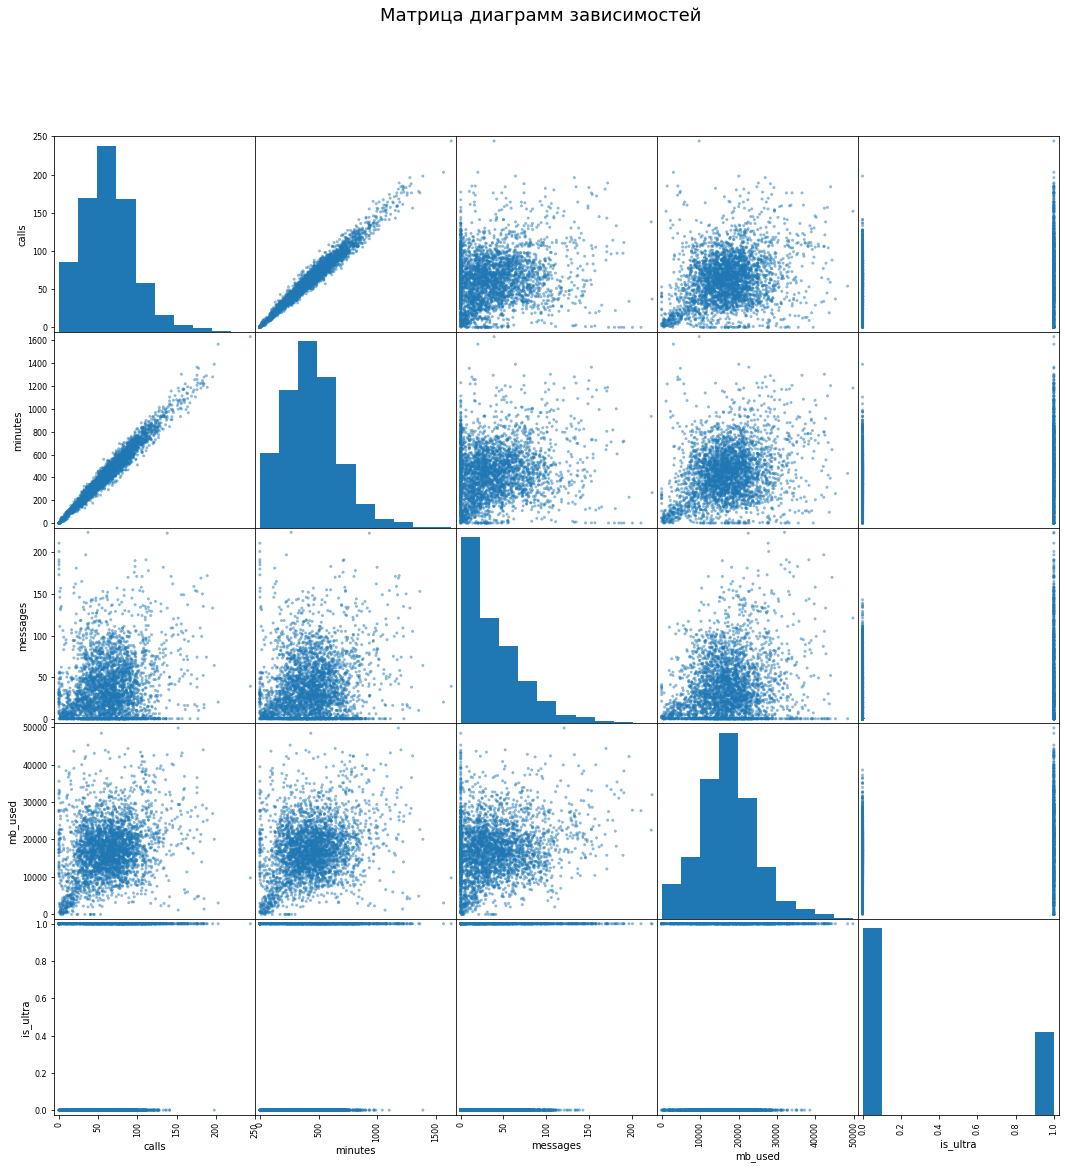

In [10]:
# оценим на мультиколлинеарность факторов
# две переменные коллинеарны, когда они находятся между собой в линейной зависимости, если коэффициент корреляции более 0,7
# Корреляция Пирсона измеряет лишь линейные связи
pd.plotting.scatter_matrix(df,figsize=(18, 18))
plt.suptitle("Матрица диаграмм зависимостей", size=18)
plt.show()

Между `calls` и `minutes` видна сильная линейная положительная корреляция (строгая прямая связь). 

Мультиколлинеарность — корреляция независимых переменных, которая затрудняет оценку и анализ общего результата. Когда независимые переменные коррелируют друг с другом, говорят о возникновении мультиколлинеарности. Мультиколлинеарность может стать причиной переобучаемости модели, что приведет к неверному результату. Кроме того, избыточные коэффициенты увеличивают сложность модели машинного обучения, а значит, время ее тренировки возрастает.

Две переменных коллинеарны, когда они находятся между собой в линейной зависимости, если коэффициент корреляции более 0,7. Посмортрим коэффициенты корреляции.

In [11]:
# Посмортрим коэффициенты корреляции

corr  = df.corr()\
        .sort_values('calls', ascending=False)\
        .filter(items = ['calls'])\
        .reset_index()
corr.style.background_gradient('coolwarm')

,index,calls
0,calls,1.000000
1,minutes,0.982083
2,mb_used,0.286442
3,is_ultra,0.207122
4,messages,0.177385


Коэфициент корреляции Пирсона между признаками `calls` и `minutes` равен 0,98, что говорит о ярком проявлении линейной связи между ними.
Признаки `calls` и `minutes` - *мультиколлинеарны*.
Чтобы избавиться от мультиколлинарности, необходимо исключить из модели один из факторов. Так как данные о количестве звонков (calls) не являются необходимым признаком для определения тарифа, то избавимся от данной колонки, чтобы избежать негативного воздействия этого явления на обучаемую модель.

Но, между `is_ultra` и `minutes` корреляцию не посмотреть. Т.к. Одна величина - номинальная (в виде 0 и 1, т.е. да/нет можно сказать), другая количественная. Поэтому для таких ситуаций подойдёт другая техника - сравнение групп. Так понимаю, надо бы сфорировать нулевую и альтернативную гипотезы, но не могу сообразить, как лучше сформултровать их. Что поробую сделать ниже.

Проверка гипотезы:

- Нулевая гипотеза H0 — средние двух выборок по `minutes` равны.
- Односторонняя альтернативная гипотеза H1 — средние двух выборок по `minutes` не равны.


Пороговое значение α = 5% ( .05)

In [12]:
is_ultra_nul = df.query('is_ultra == 1')['minutes']
is_ultra_one = df.query('is_ultra == 0')['minutes']

Но для начала посмотрим, нормальное ли распределение?

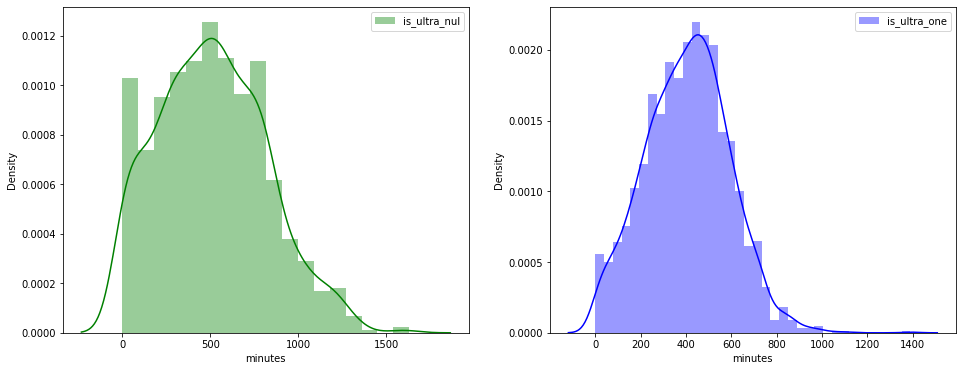

In [13]:
fig = plt.figure(figsize=(16,6))
ax_1 = fig.add_subplot(1, 2, 1)
ax_1  = sns.distplot(is_ultra_nul, kde=True, label='smart', color='green')

ax_2 = fig.add_subplot(1, 2, 2)
ax_2  = sns.distplot(is_ultra_one, kde=True, label='ultra', color='blue') 

ax_1.legend(['is_ultra_nul'])
ax_2.legend(['is_ultra_one'])

Да, распределение похоже на нормальное, можно использовать критерий Стьюдента.

In [112]:
is_ultra_nul = df.query('is_ultra == 1')['minutes']
is_ultra_one = df.query('is_ultra == 0')['minutes']

alpha = .05

results = st.ttest_ind(
    is_ultra_nul, 
    is_ultra_one, 
    equal_var=False) #не равными дисперсии выборок

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.3446735422636459e-22
Отвергаем нулевую гипотезу


Вывод: Cтатистический тест дал возможность опровергнуть нулевую гипотезу о том, что средние двух выборок по `minutes` равны.

### Вывод:

- Данные состоят из 3214 наблюдений и 5 столбцов. Предобработка данных не понадобится, пропусков нет, а все данные в нужном формате.
- Коэфициент корреляции Пирсона между признаками `calls` и `minutes` равен 0,98, что говорит о ярком проявлении линейной связи между ними. Признаками `calls` и `minutes` - **мультиколлинеарны**.
- Между `is_ultra` и `minutes` корреляцию не посмотреть. Применила технику - сравнение групп. Сфоримровала гипотезы, статистический тест дал возможность опровергнуть нулевую гипотезу о том, что средние двух выборок по `minutes` равны. Следовательно, группы **неравные** между собой, а значит, можно предположить, что может быть внияние `minutes` на `is_ultra` (целевую переменую). Для чего все это нужно? Думаю мы просто подвердили, что есть смысл учитывать признак в нашей будущей модели (не стоит удалять).
- Чтобы избавиться от мультиколлинарности, необходимо исключить из модели один из факторов. Так как данные о количестве звонков `calls` *не являются необходимым признаком* для рекомендации тарифа, то избавимся от данной колонки, чтобы избежать негативного воздействия этого явления на обучаемую модель.  Можно приступать к разделению данных на выборки.

## Разбейте данные на выборки

Выведем признаки очистив их от лишних данных и присвоим features и целевой признак присвоим переменной target:

In [113]:
# извлекаем признаки 
# извлекаем целевой признак
features = df.drop(['calls','is_ultra'], axis=1)
target = df['is_ultra']

Теперь необходимо разделить данные на валидационную, тестовую и тренировочную выборки.

Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры
тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1. Соответственно исходные данные разбиваем в соотношении 60%:20%:20%.

In [114]:
# отделяем 20% данных для временной тестовой выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.8,random_state=12345)

In [115]:
# делим временную тестовую выборку на тестовую и валидационную поровну (50%:50%)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, train_size=0.5,random_state=12345)

In [116]:
# Проверим размеры выборок
print('Размер тренериующей выборки', features_train.shape[0])
print('Размер валидационной выборки', features_valid.shape[0])
print('Размер тестовой выборки', features_test.shape[0])

Размер тренериующей выборки 2571
Размер валидационной выборки 322
Размер тестовой выборки 321


### Вывод:

Данные разделены на три выборки в соотношении 3:1:1 (60%:20%:20%) :
- Обучающая: `features_train` - признаки, `target_train` - целевой признак
- Валидационная: `features_valid` - признаки, `target_valid` - целевой признак
- Тренировочная: `features_test` - признаки, `target_test` - целевой признак

## Исследуйте модели

### Исследую модель `Дерево решений`.

In [117]:
best_model = None
best_result = 0
max_depth = 0

for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучаю модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучаю модель
    predictions = model.predict(features_valid) # получаю предсказания модели
    result = accuracy_score(target_valid, predictions) # посчитаю качество модели
    if result > best_result:
        best_model = model
        best_result = result
        max_depth = depth
        
print("Accuracy лучшей модели:", best_result)
print("лучшая глубина:", max_depth)

Accuracy лучшей модели: 0.7888198757763976
лучшая глубина: 8


Итоговая точность модели `Решающее дерево` с минимальными значениями гиперпараметров:

Accuracy лучшей модели дерева решений : 0.7888198757763976

В целях избежания возможного переобучения модели, пробуем уменьшать гиперпараметр `max_depth` (максимально допустимая глубина дерева), выяснили, что лучшая глубина: 8.

### Исследую модель `Случайный лес`

In [118]:
best_model = None
best_result = 0
best_est = 0
max_deph = 0

for est in range(1, 25):
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=12345, max_depth=depth) # обучаю модель с заданными гиперпараметрами
        model.fit(features_train, target_train) # обучаю модель на тренировочной выборке
        result = model.score(features_valid, target_valid) # посчитайю качество модели на валидационной выборке
        if result > best_result:
            best_model = model # сохраняю наилучшую модель
            best_result = result  # сохраняю наилучшее значение метрики accuracy на валидационных данных
            best_est = est
            max_depth=depth
        
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("лучшее количество деревьев:", best_est)
print("лучшая глубина:", max_depth)

Accuracy наилучшей модели на валидационной выборке: 0.8012422360248447
лучшее количество деревьев: 1
лучшая глубина: 7


Итоговая точность модели `Случайный лес` с минимальными значениями гиперпараметров:

Accuracy наилучшей модели на валидационной выборке: 0.8012422360248447
лучшое количество деревьев: 1
лучшая глубина: 7

### Исследую модель `Логистическая регрессия`

In [119]:
model = LogisticRegression(random_state=12345)  # инициализирую модель логистической регрессии с параметром random_state=12345
model.fit(features_train, target_train) # обучаю модель на тренировочной выборке
result = model.score(features_valid, target_valid) # получаю метрику качества модели на валидационной выборке

print("Accuracy модели логистической регрессии на валидационной выборке:", result)

Accuracy модели логистической регрессии на валидационной выборке: 0.7142857142857143


Итоговая точность модели `Логистическая регрессия`:
Accuracy модели логистической регрессии на валидационной выборке: 0.7142857142857143

**Вывод:**

 * *Самым быстрым и наименее точным оказался метод* ***`Логистической регрессии`***.
 <font color='blue'>*Accuracy = 0.6982892690513219.*</font> *- Не проходит по заданной точности 0.75*   

 * *Наиболее точным (из мной проверенных вариаций), НО, вероятно, наиболее долгим является метод* ***`RandomForestClassifier(Случайный лес)`***.  
<font color='blue'>*Accuracy = 0.8149300155520995.*</font> 
  
 * *Наиболее оптимальным с точки зрения точность/время выполнения является метод* ***`DecisionTreeClassifier(Дерева решений)`***.  
<font color='blue'>*Accuracy = 0.7962674961119751.*</font>   

## Проверьте модель на тестовой выборке

1. *Протестируем качество модели* ***`Дерева решений`*** *на тестовой выборке.  
Выбрала оптимальный вариант с гиперпараметром:  
`max_depth` = 7*

In [120]:
model_tree_test = DecisionTreeClassifier(random_state=12345, max_depth=7) # обучили модель на тренировочной выборке с заданными гиперпараметрами
model_tree_test.fit(features_train,target_train)

test_predictions_tree = model_tree_test.predict(features_test)


result = model_tree_test.score(features_test, target_test) # получили метрику качества модели на тестовой выборке
print("Accuracy модели Дерево решений на тестовой выборке:", result)

Accuracy модели Дерево решений на тестовой выборке: 0.7819314641744548


2. *Протестируем качество модели* ***`Случайный лес`*** *на тестовой выборке.  
Выбрала оптимальный вариант с гиперпараметрами:  
`n_estimators` = 7
`max_depth` = 8*

In [121]:
model_forest_test = RandomForestClassifier(random_state=12345, n_estimators=7, max_depth=8) 
model_forest_test.fit(features_train,target_train)
test_predictions_forest = model_forest_test.predict(features_test)

result = model_forest_test.score(features_test, target_test) # получили метрику качества модели на тестовой выборке
print("Accuracy модели Случайный лес на тестовой выборке:", result)

Accuracy модели Случайный лес на тестовой выборке: 0.7975077881619937


### Вывод:

- На тестовой выборке модели `DecisionTreeClassifier`(Дерево решений) и `RandomForestClassifier`(Случайный лес) показали практически одинаковую точность `0.78`.

- С учетом того, что модель `DecisionTreeClassifier`(Дерево решений) работает быстрее, целесообразнее выбрать ее в качестве алгоритма предсказания оптимальных тарифов, в случае большого набора данных.

## Проверка модели на адекватность

**Вероятность ошибки случайной модели - 50%.  
Вероятность же ошибки выбранных моделей - 22%, что естественно ниже.  
Следует считать данные модели адекватными.**

Буду использовать **`DummyClassifier`  библиотеки `Sklearn`** - это классификатор, который делает прогнозы, используя простые правила.

Этот классификатор служит простой базой для сравнения с другими более сложными классификаторами.

Конкретное поведение базовой линии выбирается с помощью `strategy` параметра.

Все стратегии делают прогнозы, которые игнорируют значения входных признаков, переданные в качестве X аргумента для fitи predict. Однако прогнозы обычно зависят от значений, наблюдаемых в yпараметре, переданном в fit.

**Сравним с двумя вариантами данного классификатора, используя аргументы `strategy`:**
- `most_frequent` -  который всегда предсказывает наиболее частую метку в обучающем наборе.
- `uniform` -  генерирует прогнозы равномерно случайным образом из списка уникальных классов в обучающем наборе(фактически имитирует случайную модель).

In [122]:
# импортируем классификатор DummyClassifier из библиотеки sklearn
from sklearn.dummy import DummyClassifier

In [123]:
# обучим модель на тренировочной выборке с параметром uniform
dummy_uniform = DummyClassifier(strategy='uniform', random_state=12345).fit(features_train, target_train)
dummy_pred = dummy_uniform.predict(features_test) # получим предсказание

result = dummy_uniform.score(features_test, target_test) # получили метрику качества модели на тестовой выборке
print("Accuracy случайной модели на тестовой выборке:", result)

Accuracy случайной модели на тестовой выборке: 0.4766355140186916


**Вывод:**
Как и предполагалось вероятность "случайного метода" - 50/50

In [124]:
# обучим модель на тренировочной выборке с параметром most_frequent
dummy_most_frequent = DummyClassifier(strategy="most_frequent", random_state=12345).fit(features_train, target_train)
dummy_pred_mf = dummy_most_frequent.predict(features_test) # получим предсказание

result = dummy_most_frequent.score(features_test, target_test) # получили метрику качества модели на тестовой выборке
print("Accuracy случайной модели на тестовой выборке:", result)

Accuracy случайной модели на тестовой выборке: 0.6791277258566978


**Вывод:**
Данный метод выдал вероятность ошибки около 30%, что является *ниже* процента ошибки случайной модели, но *выше* обеих выбранных оптимальных моделей.

## Общий вывод

   Оптимальные модели для задачи классификации, которая выберет подходящий тариф (`Смарт` или `Ультра`), соответствующий потребностям клиентов компании "Мегалайн", пользующихся архивными тарифами:  

Модель на алгоритме классификации `DecisionTreeClassifier`(Дерево решений) с гиперпараметрами:   
`max_depth` = 7  

Данная модель обладает точностью принятия решения - 0.77 (согласно проверке на тестовой сборке), что выше порогового значения в 0.75. Предназначена для оценки больших массивов данных.

Модель на алгоритме классификации `RandomForestClassifier`(Дерево решений) с гиперпараметрами:   
`n_estimators`= 7
`max_depth` = 8 

Данная модель обладает точностью принятия решения - 0.78 (согласно проверке на тестовой сборке), что выше порогового значения в 0.75. Предназначена для оценки меньших массивов данных, ввиду более долгого времени исполнения и большей нагрузки на систему.